In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import sys

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from keras.layers import Dense, Dropout, LeakyReLU, Input
from keras.layers import concatenate, BatchNormalization
from keras.models import Model
from keras import optimizers

import integrator

Using TensorFlow backend.


# Learn Force

##  Helper Functions

In [2]:
def read_data(path='./orbits/planet_0.npy'):
    ''' 
    Reads the data file and returns positions, momenta, and number of samples
    
    Parameters
    ----------
    path : str
        The path to the file (must have dimensions (body, time_step, coordinate), \
                  where coordinate is (x, y, z, vx, vy, vz))

    Returns
    -------
    X: float(nsamples, 4)
        Particle positions
    P: float(nsamples, 2)
        Mercury's momentum
    nsamples: int
        The number of samples
    '''
    try:
        orbits = np.load(path)
    except:
        sys.exit('No File found. Please provide Path to file')
 
    try:  
        _, nsamples, _ = orbits.shape
    except:
        sys.exit('File should have dimensions (body, time_step, coordinate), \
                  where coordinate is (x, y, z, vx, vy, vz)')

    # Create empty arrays for positions, distances and velocities (X, D, P)
    X=np.empty([nsamples, 4]) # x1, y1, x2, y2
    P=np.empty([nsamples, 2]) # px,  py (Mercury's momentum, Sun's momentum is -p)

    # Get positions
    X1 = orbits[0,:,0].T
    Y1 = orbits[0,:,1].T
    X2 = orbits[1,:,0].T
    Y2 = orbits[1,:,1].T
    X[:,0] = X1
    X[:,1] = Y1
    X[:,2] = X2
    X[:,3] = Y2

    # Get planets's momentum
    P[:,0] = orbits[1,:,3].T
    P[:,1] = orbits[1,:,4].T
    P *= M_MERC

    return X, P, nsamples

def generate_dataset(npoints, D, dP_red, noise_level = 0.05):
    ''' Generates a dataset that is then fed to the MLP
    
    Parameters
    ----------
    npoints: int
        The number of training points that will be generated
    D: float(nsamples, 2)
        The distances between planets (Dx, Dy)
    dP_red: float(nsamples-1, 2)
        The momentum update at each point, normalized. 
    noise level: float
        The fractional magnitude of the noise introduced. Defaults to 0.05
        
    Returns
    -------
    X_out, Y_out: float(nsamples, 2)
        The input and output that will be used by the MLP
    '''
    X_out = np.zeros([npoints, 2])
    Y_out = np.zeros([npoints, 2])
    ran = range(1, nsamples-1, 1)
    indices = np.random.choice(ran, size = npoints)
    if noise_level > 0: X_noise = np.random.normal(0, noise_level, X_out.shape)

    for i in range(npoints):
        X_out[i] =  D[indices[i]]
        Y_out[i] =  dP_red[indices[i]]

    if noise_level>0: X_out += X_out*X_noise

    return X_out, Y_out

### Model

In [3]:
class simple_leaky:
    """
    A simple MLP with LeakyReLU activation
    """
    
    def __init__(self, input_size, output_size, learning_rate=None):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.output_size = output_size
        
    def model(self):
        print(self.input_size)
        
        input_data = (Input(shape=(self.input_size,)))

        x1 = Dense(100, input_dim=self.input_size, kernel_initializer='normal')(input_data)
        x1 = LeakyReLU(alpha=0.1)(x1)
        x2 = Dense(100, kernel_initializer='normal')(x1)
        x2 = LeakyReLU(alpha=0.1)(x2)
        # x2 = Dropout(0.5)(x2)
        x3 = Dense(100, kernel_initializer='normal')(x2)
        x3 = LeakyReLU(alpha=0.1)(x3)
        x3 = Dense(100, kernel_initializer='normal')(x3)
        x3 = LeakyReLU(alpha=0.1)(x3)
        # x3 = Dropout(0.5)(x3)
        x4 = Dense(self.output_size, kernel_initializer='normal')(x3)
        

        dense_model = Model(input_data, x4)
        dense_model.summary()

        if self.learning_rate is None:
            # dense_model.compile(optimizer='adam', loss='mse')
            dense_model.compile(optimizer='adam', loss='mean_absolute_error')
        else:
            dense_model.compile(optimizer=optimizers.Adam(lr=self.learning_rate), loss='mean_absolute_error')

        return dense_model

## Prepare Data

In [4]:
# Global constants
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
M_SUN = 1.98892 * 10**30 # kg
M_MERC = 0.33011 * 10**24 #kg
DELTA_TIME = 0.1*DAY/YEAR

# Read data
X, P, nsamples = read_data()

# Planet distances
D = X[:,2:] - X[:,:2]

# Momentum difference
dP = P[1:] - P[:-1]

# Normalize the planet's momentum difference
STD_P = np.std(dP)
dP_red = dP/STD_P# Fitting parameters

npoints_training=100000
npoints_test=5000
noise_level = 0.05 # How much to perturb the points being learned
EPOCHS = 1000
patience = 20

# Get train and test data
X_train, Y_train = generate_dataset(
    npoints_training, D, dP_red, noise_level)
X_test, Y_test = generate_dataset(
    npoints_test, D, dP_red, noise_level = 0)

# Convert data to Pandas arrays
train_dataset = pd.DataFrame(X_train, columns=["dx", "dy"])
train_labels = pd.DataFrame(Y_train, columns=["dPx_merc", "dPy_merc"])
test_dataset = pd.DataFrame(X_test, columns=["dx", "dy"])
test_labels = pd.DataFrame(Y_test, columns=["dPx_merc", "dPy_merc"])


# Fit Data

In [5]:
#@title Fit { form-width: "30%" }

model_instance = simple_leaky(
    train_dataset.shape[1], train_labels.shape[1], learning_rate=1e-3)
model = model_instance.model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=patience)

early_history = model.fit(train_dataset, train_labels, 
                    epochs=EPOCHS, validation_split = 0.1, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

2
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
__________________________________________

# Performance Plots

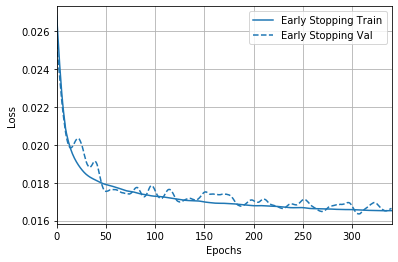

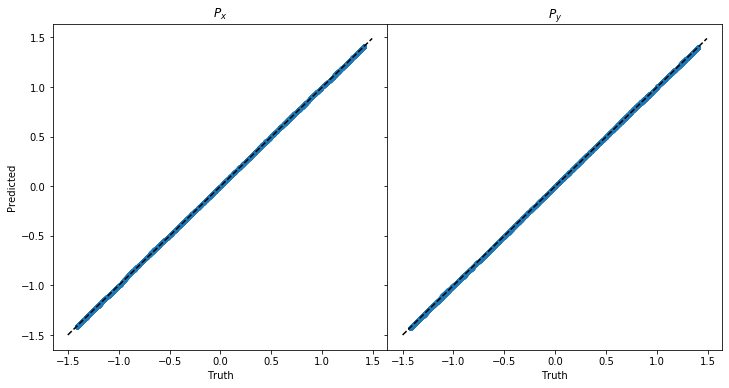

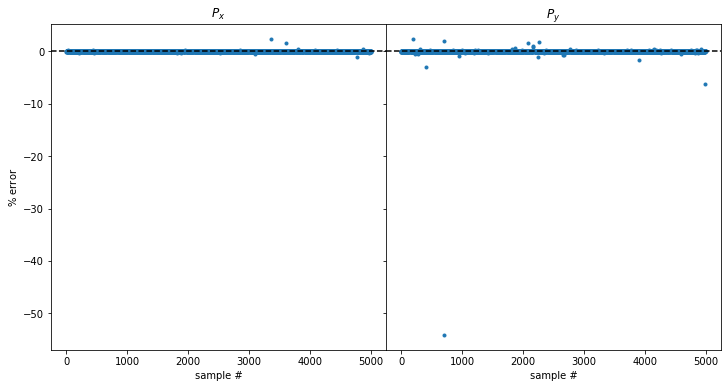

In [6]:
# Get test predictions
test_predictions = model.predict(test_dataset)
z = np.arange(len(test_predictions[:,0]))
zz = np.arange(-1.5, 1.5, 0.01)

# Loss
fig = plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Early Stopping': early_history}, metric = "loss")
plt.ylabel('Loss')
plt.show()

# Predicted v Truth
fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.)

ax1.set_xlabel('Truth')
ax1.set_title('$P_x$')
ax1.set_ylabel('Predicted')

ax2.set_xlabel('Truth')
ax2.set_title('$P_y$')

ax1.scatter(
    test_labels["dPx_merc"].values, test_predictions[:,0],marker = '.')
ax1.plot(zz,zz,ls='--', color='k')

ax2.scatter(
    test_labels["dPy_merc"].values, test_predictions[:,1],marker = '.')
ax2.plot(zz,zz,ls='--', color='k')
plt.show()

# Predicted v Truth (Percent errors)
fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.)

ax1.set_xlabel('sample #')
ax1.set_title('$P_x$')
ax1.set_ylabel('$\%$ error')

ax2.set_xlabel('sample #')
ax2.set_title('$P_y$')

ax1.scatter(
    z, (test_predictions[:,0]-test_labels["dPx_merc"].values
        )/test_labels["dPx_merc"].values,marker = '.')
ax1.axhline(0, ls = '--', color = 'k')

ax2.scatter(
    z, (test_predictions[:,1]-test_labels["dPy_merc"].values
        )/test_labels["dPy_merc"].values,marker = '.')
ax2.axhline(0, ls = '--', color = 'k')

# Integrator

In [7]:
x_pred, dp_pred = integrator.integrate_leapfrog(
    X0 = X[0], 
    P0 = P[0], 
    dt = DELTA_TIME, 
    m1 = M_SUN, 
    m2 = M_MERC, 
    nsteps = 5000, 
    model = model, 
    norm_p = STD_P)

In [8]:
#@title Plot Predicted v True trajectories { form-width: "30%" }

shift = 0.5/880*np.arange(nsteps)

fig = plt.figure()
plt.scatter(X[:nsteps,2]+shift, X[:nsteps,3]+shift, marker ='o', label = 'true', color='blue')
plt.scatter(x_pred[:nsteps,2]+shift, x_pred[:nsteps,3]+shift, marker ='.', label = 'predicted', color='orange')
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Mercury's Orbit")
plt.legend()
#plt.savefig('orbits.pdf')

NameError: name 'nsteps' is not defined

# To do:

- Clean up code and merge it with other existing code in the repo
- Add a third planet
- Convert to GraphNets